In [1]:
import os
import glob

import pandas as pd
import numpy as np
import datetime

from skimage import io
from datetime import timedelta
from datetime import datetime
from scipy.stats import pearsonr

from netCDF4 import Dataset

# Imports for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter 
from matplotlib.ticker import MultipleLocator, FormatStrFormatter 
from matplotlib.dates import MonthLocator
import matplotlib.patheffects as PathEffects

## font sizes

In [2]:
fs_titles = 24
fs_labels = 24
fs_axes = 20
fs_text = 20
fs_legend = 20

## load data histogram dataframe

In [3]:
#mm path
# df_h = pd.read_csv('/Users/megmason/Desktop/outputs/histogram_df.csv',index_col=0)

#ars path
df_h = pd.read_csv('/home/meganmason/Documents/projects/thesis/figures/tables/histogram_df.csv',index_col=0)
# binx = np.arange(0,1000,30) #set bin sizes to have as index
df_h

# pd.to_datetime(df_h.columns[0]).strftime("%Y")

,2013-04-03,2013-04-29,2013-05-03,2013-05-25,2013-06-01,2013-06-08,2014-03-23,2014-04-07,2014-04-13,2014-04-20,...,2017-03-03,2017-04-01,2017-05-02,2017-06-04,2017-07-09,2017-07-17,2017-07-27,2017-08-16,2018-04-23,2018-05-28
0,11939930,14492016,14149379,10352002,8496363,6813639,14575297,14289932,13801321,11952963,...,3734712,4561493,5505172,7841711,6904534,5011025,2794947,923170,12216054,9257357
30,10604904,10245900,9546177,5854912,4370306,2577140,13885180,13342293,13193806,11192225,...,4187190,4523526,3893722,5937692,4233230,2716576,1278689,373825,12723788,7052135
60,9604871,8875702,7905614,3924401,2761500,1383532,13288261,13005864,13312664,11036612,...,4439869,4241300,3822079,5436903,3382450,2040749,934067,280009,13868724,6170597
90,9199567,7602102,6387717,2706986,1878462,898117,12552175,12854792,13074121,10611180,...,4685584,4272276,4231215,5790431,2828785,1600382,740580,233088,14580365,4943048
120,8776834,6042986,4684999,1842198,1306242,620342,9971570,12308798,10999406,8655352,...,4915874,4584846,4963797,6346478,2315836,1257456,610091,197757,13291083,3377909
150,7773111,4327446,3189996,1246013,917244,444850,6037143,9834469,7084380,5810450,...,5264391,5068985,5947825,6767864,1842309,994642,504689,170219,10696794,2136899
180,6264531,2869149,2085772,834871,631116,309769,2955791,6253733,3693259,3434740,...,5625231,5732551,6945905,6965272,1441111,797543,422198,146910,7787611,1340373
210,4512768,1860062,1355365,573154,442327,218878,1433866,3325345,1835463,1929054,...,6029269,6537140,7749430,6694110,1130413,653900,355335,126137,5254572,846931
240,2950282,1199043,882428,395432,307594,158270,754949,1697815,966611,1065868,...,6497549,7373330,8014030,5996995,897940,537272,294096,106177,3297683,548966
270,1842234,784863,584650,274429,218626,114177,426345,912515,545380,601895,...,6997743,7872728,7744754,5175065,728014,446317,248164,91474,1982887,366634


In [ ]:
df_h.shape

## plot histograms

In [ ]:
# for column in df_h:
#     plt.figure(figsize=(10,3))
#     df_h[column][:-1].plot.bar(width=0.85, align='edge') #bar plot of each column (minus the last row)
#     plt.title(str(column), fontsize=fs_titles)
#     plt.xlabel('snow depth [cm]', fontsize=fs_axes); plt.ylabel('frequency', fontsize=fs_axes)
#     plt.xlim(-.5,34) #34 is # of bins to display -- 34x30cm = 1000+cm (i.e. 10m)

In [ ]:
# df_h.info()
#print(type(df_h.columns))
#df_h.columns.unique() #nunique for number unique
#df_h.groupby
# pd.to_datetime(df_h.columns[0]).strftime("%Y")
# df_h.groupb

#df_h.set_index(pd.to_datetime(df_h.index), inplace=True)
# for year in df_h:
#     plt.figure(figsize=(5,5))
#     df_h.column.plot.bar(width=0.85, align='edge')



In [4]:
df_h = df_h.T

In [5]:
df_h.set_index(pd.to_datetime(df_h.index), inplace=True) #inplace doesn't make a copy, overwrites
df_h

,0,30,60,90,120,150,180,210,240,270,...,2220,2250,2280,2310,2340,2370,2400,2430,2460,zeros
2013-04-03,11939930,10604904,9604871,9199567,8776834,7773111,6264531,4512768,2950282,1842234,...,0,0,0,0,0,0,0,0,0,54394576
2013-04-29,14492016,10245900,8875702,7602102,6042986,4327446,2869149,1860062,1199043,784863,...,0,0,0,0,0,0,0,0,0,71281625
2013-05-03,14149379,9546177,7905614,6387717,4684999,3189996,2085772,1355365,882428,584650,...,0,0,0,0,0,0,0,0,0,79180816
2013-05-25,10352002,5854912,3924401,2706986,1842198,1246013,834871,573154,395432,274429,...,0,0,0,0,0,0,0,0,0,102545995
2013-06-01,8496363,4370306,2761500,1878462,1306242,917244,631116,442327,307594,218626,...,0,0,0,0,0,0,0,0,0,109337657
2013-06-08,6813639,2577140,1383532,898117,620342,444850,309769,218878,158270,114177,...,0,0,0,0,0,0,0,0,0,117367234
2014-03-23,14575297,13885180,13288261,12552175,9971570,6037143,2955791,1433866,754949,426345,...,0,0,0,0,0,0,0,0,0,54646865
2014-04-07,14289932,13342293,13005864,12854792,12308798,9834469,6253733,3325345,1697815,912515,...,0,0,0,0,0,0,0,0,0,41988573
2014-04-13,13801321,13193806,13312664,13074121,10999406,7084380,3693259,1835463,966611,545380,...,0,0,0,0,0,0,0,0,0,51802956
2014-04-20,11952963,11192225,11036612,10611180,8655352,5810450,3434740,1929054,1065868,601895,...,0,0,0,0,0,0,0,0,0,63950939


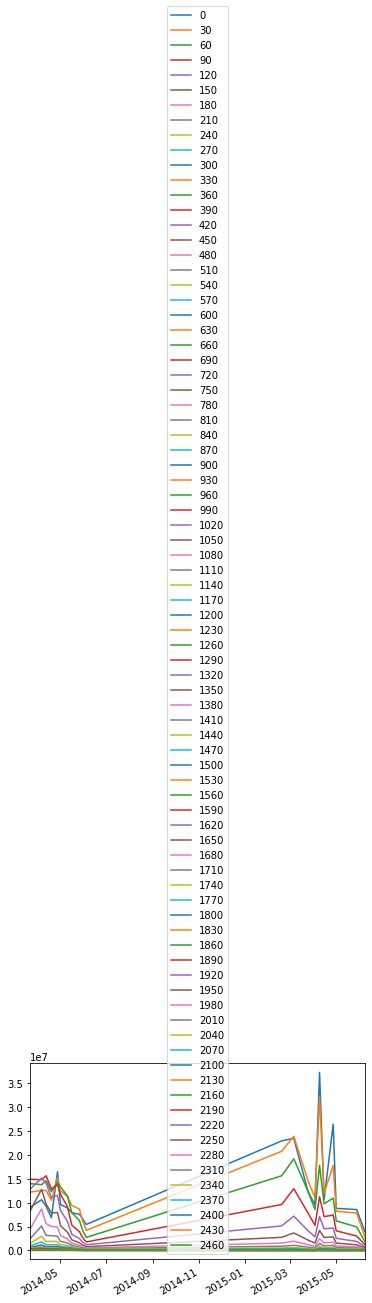

In [28]:

df_h.loc[:, df_h.columns != 'zeros'].plot()


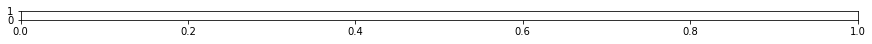

In [12]:
fig = plt.figure(figsize=(15,10))

for i, (name, row) in enumerate(df_h.loc[:, df_h.columns != 'zeros'].iterrows()):
    ax = plt.subplot(i+1,1, i+1)
#     print('name',name)
#     print('row',row)

     df_h[row][:-1].plot.bar(width=0.85, align='edge')

In [17]:
df_h.index


for row in df_h:
    plt.figure(figsize=(10,3))
    df_h.index.plot.bar(width=0.85, align='edge') #bar plot of each column (minus the last row)
    plt.title(str(column), fontsize=fs_titles)
    plt.xlabel('snow depth [cm]', fontsize=fs_axes); plt.ylabel('frequency', fontsize=fs_axes)
    plt.xlim(-.5,34) #34 is # of bins to display -- 34x30cm = 1000+cm (i.e. 10m)





# for column in df_h:
#     plt.figure(figsize=(10,3))
#     df_h[column][:-1].plot.bar(width=0.85, align='edge') #bar plot of each column (minus the last row)
#     plt.title(str(column), fontsize=fs_titles)
#     plt.xlabel('snow depth [cm]', fontsize=fs_axes); plt.ylabel('frequency', fontsize=fs_axes)
#     plt.xlim(-.5,34) #34 is # of bins to display -- 34x30cm = 1000+cm (i.e. 10m)

AttributeError: 'DatetimeIndex' object has no attribute 'plot'

<Figure size 720x216 with 0 Axes>

In [21]:
fl_yrs = df_h.groupby(df_h.index.year).groups #.groups makes dictionary
fl_yrs

{2013: DatetimeIndex(['2013-04-03', '2013-04-29', '2013-05-03', '2013-05-25',
                '2013-06-01', '2013-06-08'],
               dtype='datetime64[ns]', freq=None),
 2014: DatetimeIndex(['2014-03-23', '2014-04-07', '2014-04-13', '2014-04-20',
                '2014-04-28', '2014-05-02', '2014-05-11', '2014-05-17',
                '2014-05-27', '2014-05-31', '2014-06-05'],
               dtype='datetime64[ns]', freq=None),
 2015: DatetimeIndex(['2015-02-18', '2015-03-06', '2015-03-25', '2015-04-03',
                '2015-04-09', '2015-04-15', '2015-04-27', '2015-05-01',
                '2015-05-28', '2015-06-08'],
               dtype='datetime64[ns]', freq=None),
 2016: DatetimeIndex(['2016-03-26', '2016-04-01', '2016-04-07', '2016-04-16',
                '2016-04-26', '2016-05-09', '2016-05-27', '2016-06-07',
                '2016-06-13', '2016-06-20', '2016-06-25', '2016-07-01',
                '2016-07-08'],
               dtype='datetime64[ns]', freq=None),
 2017: DatetimeI

TypeError: only size-1 arrays can be converted to Python scalars

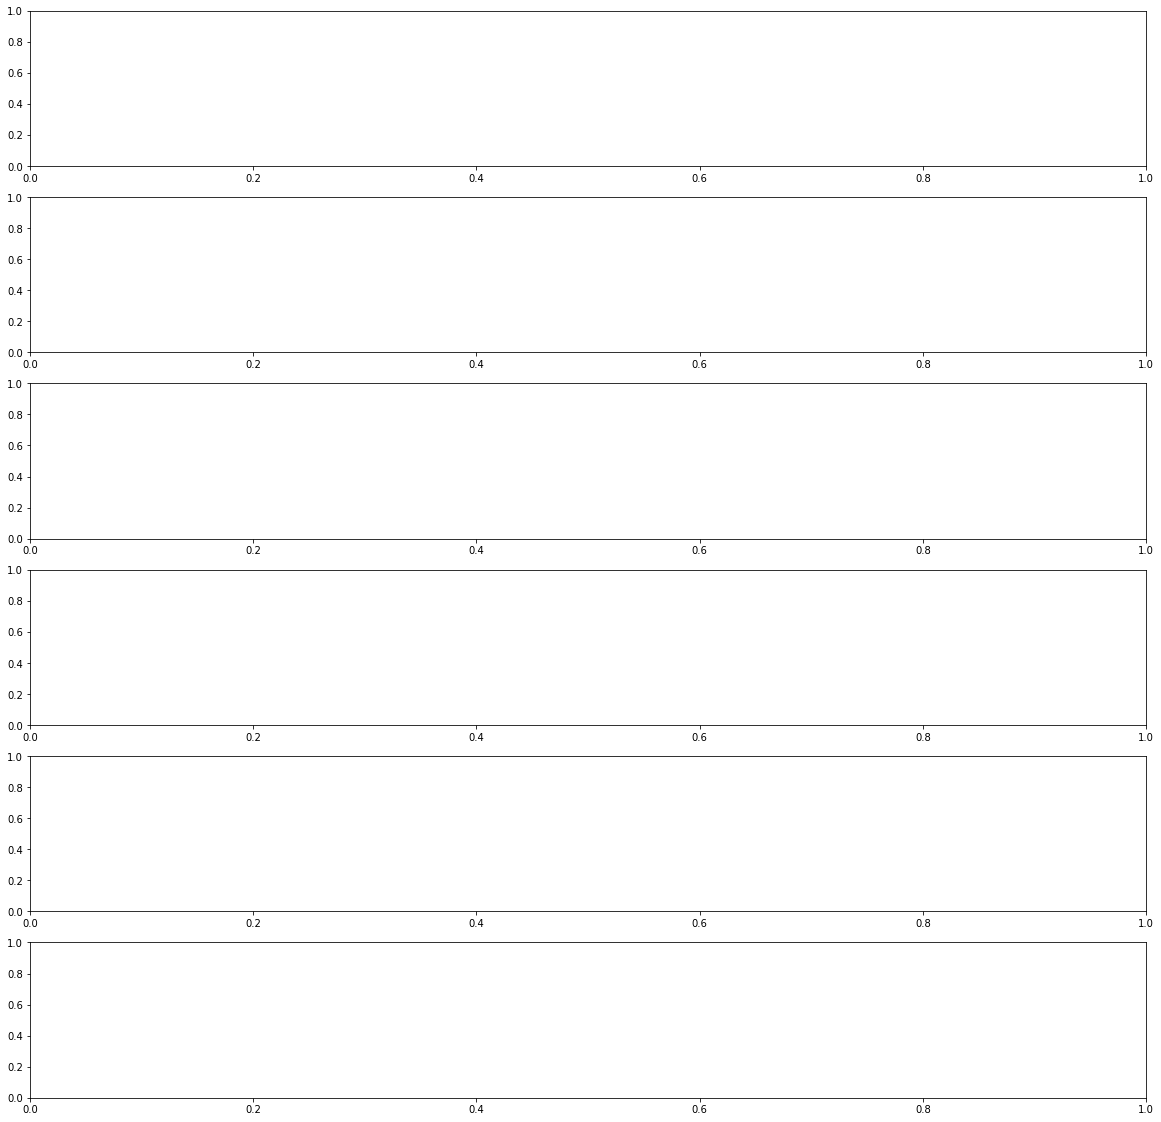

In [118]:
#lots of trial and error....
years=range(2013,2019)

# fig,axs=plt.subplots(6)
# fig,axs=plt.subplots(nrows = 3, ncols = 2)
fig,axs=plt.subplots(6,figsize = (20,20))
# axs=axs.flatten()

for i,year in enumerate(years):
#     print(year)
    df_nozeros = df_h.loc[:, df_h.columns != 'zeros']
    df_nozeros = df_nozeros.loc[fl_yrs[year] ]
    df_nozeros
#     break
# df_nozeros    
#     axs[i].plot(df_nozeros)
    axs[i].bar(range(0,83),df_nozeros)
#     axs[i].plot(kindrange(len(df_nozeros.columns)),df_nozeros.values)
#     df_nozeros.plot(kind='bar', ax=axs[i], legend=False)
#     for ax in axs.flat:
#         for column in df_nozeros:
#             df_nozeros[column].plot.bar(width=8.5,align='edge')


# len(df_nozeros.columns)
  

In [136]:
#ernesto wrote this
def step_plot_series(bin_lower, freq_series, divide_value = 1):
    
    x_series = []
    y_series = []
    
    for i_bin in range(len(bin_lower)-1):
        x_series += [bin_lower[i_bin], bin_lower[i_bin+1]]
        y_series += [freq_series[i_bin]/divide_value, freq_series[i_bin]/divide_value]

    return x_series, y_series
        

164 164


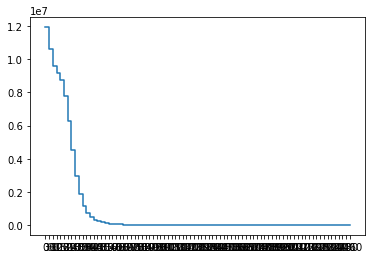

In [139]:
[x_test, y_test] = step_plot_series(df_h.iloc[0,:-1].index, df_h.iloc[0,:-1].values)
print(len(x_test), len(y_test))
plt.plot(x_test, y_test)

In [ ]:
# df_nozeros  


#     for ax in axs.flat:
# #         df_h[column][:-1].plot.bar(width=0.85, align='edge')
#         df_nozeros[column].plot.bar(width=0.85, align='edge')
# #         bx = ax.plot.bar(df_nozeros)

# #     ax.set_title('{}'.format(years[z]))
#     # plot
# #     axs[i].plot.bar[df_nozeros]
#     plt.title('{}'.format(year))
    
# plt.tight_layout()
# plt.show() 

In [124]:
df_h.iloc[0,:-1].values

array([11939930, 10604904,  9604871,  9199567,  8776834,  7773111,
        6264531,  4512768,  2950282,  1842234,  1158672,   744869,
         482638,   322230,   220556,   153169,   110058,    76017,
          53894,    40974,    31472,    22227,    10706,      648,
              0,        0,        0,        0,        0,        0,
              0,        0,        0,        0,        0,        0,
              0,        0,        0,        0,        0,        0,
              0,        0,        0,        0,        0,        0,
              0,        0,        0,        0,        0,        0,
              0,        0,        0,        0,        0,        0,
              0,        0,        0,        0,        0,        0,
              0,        0,        0,        0,        0,        0,
              0,        0,        0,        0,        0,        0,
              0,        0,        0,        0,        0])